In [135]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.stats import multivariate_normal
import pandas as pd
import sklearn


import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Dropout, BatchNormalization, LeakyReLU, Lambda
from keras.losses import Loss, mse, MeanSquaredError
from keras.optimizers import Optimizer, Adam
from keras.metrics import Mean
from keras.utils import to_categorical, plot_model, load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.models import load_model

import tensorflow_probability as tfp

np.random.seed(1234)
tf.random.set_seed(1234)

In [136]:
def printest(args, value):
    return print( "{} : \n {} \n".format(args, value) )

# BPINN: Boltzmann-BGK

The two-dimensional, static case of the Boltzmann-BGK equation, is expressed as:

$$
\begin{equation*}
\xi_x \cdot \frac{\partial f}{\partial \mathbf{x}} + \xi_y \cdot \frac{\partial f}{\partial \mathbf{y}} = -\frac{1}{\tau} (f - f^{eq}) ,~~ t \in \mathbb{R}^{+}, ~~ \mathbf{r} \in \mathbb{R}^3, ~~\mathbf{v} \in \mathbb{R}^3.
\end{equation*}
$$

Here, $\mathbf{\xi}= \mathbf{\xi}(\xi_x,\xi_y)$ represents the velocities of particles in the fluid.

The problem I am focusing on is the Kovasznay flow, simulating a two-dimensional, steady, incompressible flow within a rectangular domain defined by $-1/2 \leq x \leq 2$ and $−1/2\leq y \leq 3 /2$. The exact solutions for this flow are given as:

$$
\begin{align*}
u(x,y) &= u_o[1- \exp(\lambda x)\cos{(2 \pi y)}],\\
v(x,y) &= v_o[2 \pi \exp(\lambda x)\sin{(2 \pi y)}],\\
p(x,y) &= p_o[1- \exp(2\lambda x)] + C.
\end{align*}
$$

For the model, two Bayesian Neural Networks (BNNs) are deployed to approximate the equilibrium (Maxwellian) and non-equilibrium distribution functions. The inputs to these BNNs are spatial variables $x$ and $y$ alongside particle velocities $\xi_x$ and $\xi_y$. These inputs, initially set randomly for internal and boundary points, train the BNNs to approximate the desired distribution for the Boltzmann-BGK equation. The combined outputs of the BNNs represent the system's distribution, given as:

$$
\begin{align*}
f &= f_{eq} + f_{neq},\\
f_{neq} &= f - f_{eq}.
\end{align*}
$$

The equilibrium distribution function $f^{eq}$ is a function of the local macroscopic properties of the gas, such as its density, temperature, and velocities, given by the Maxwell-Boltzmann distribution:

$$f^{eq}(\mathbf{r}, \mathbf{v}) = \left(\frac{\rho}{2\pi R T}\right) \exp\left(-\frac{|\mathbf{U}-\mathbf{\xi}|^2}{2RT}\right)$$

$f^{eq}$ can be interpreted as the distribution that the gas particles would have in the absence of any external perturbations or collisions, and it depends only on the macroscopic properties of the gas. In this distribution, $T$ is the temperature, $R$ is the Boltzmann constant,  $\rho$ is the density related to the fluid pressure as $\rho = p/RT$, $\mathbf{U}(u,v)= (u,v)$ is the fluid velocity, and $\mathbf{\xi}(\xi_x, \xi_y) = (\xi_x, \xi_y)$ the particle velocity.

This distribution $f$,and the particle macroscopic variables $u$, $v$ and $p$ provided by the Kovasznay flow problem are fed into a Dense Neural Network (DNN) part of the Physics-Informed Neural Network (PINN) model. the output of the DNN comprises the two  microscopic velocities $\xi_x$, $\xi_y$. These are then compared used with the distributio $f$ to solve the following integrals 

$$\rho  = \int \int f d\xi$$

$$u  = \frac{1}{\rho }\int \int f \xi_x d\xi$$

$$v  = \frac{1}{\rho }\int \int f  \xi_y d\xi$$

where $d\xi = d\xi_x d\xi_y  $. The values of these integrals are then compared with the corresponding macroscopic variables provided by the Kovasznay flow problem.

Furthermore, to compute $f_{neq}$, the distribution $f$ from the two BNNs is used. The automatic differentiation of $f$ generates the residual, expressed as:

$$
\begin{equation*}
R = \xi_x \cdot \frac{\partial f}{\partial \mathbf{x}}+ \xi_y \cdot \frac{\partial f}{\partial \mathbf{y}} + \frac{1}{\tau} (f_{neq}).
\end{equation*}
$$

Finally, the integrals values and residual $R$ contribute to a loss function. The minimization of this loss function iteratively refines the particle velocities $\xi_x$ and $\xi_y$ that serve as inputs to the BNNs, promoting the network's learning process.


# Automatic Diff: Layer

In [137]:
class AutomaticDiff(Layer):
    def __init__(self, dual_bnn, tau, name = 'AutomaticDiff'):

        super().__init__(name = name)
        
        self.dual_bnn = dual_bnn
        self.tau = tau

    def call(self, inputs):
        
        xy, xi = inputs 

        # Calculate the equilibrium (f_eq) and non-equilibrium (f_neq) distributions from the Maxwell distribution
        with tf.GradientTape() as g:
            g.watch(xy)
            f_neq, f_eq = self.dual_bnn(xy)  
            f = f_eq + f_neq
        dfdx_dfdy = g.batch_jacobian(f, xy)

        # Extract the partial derivatives with respect to x and y
        dfdx = tf.squeeze(dfdx_dfdy[:,:,0:1], axis = -1)  # shape: (batch_size, 3)
        dfdy = tf.squeeze(dfdx_dfdy[:,:,1:2], axis = -1)  # shape: (batch_size, 3)    
     
        xi_x = xi[:, 0:1]
        xi_y = xi[:, 1:2]
        #printest('xi_x', xi_x)
        # Compute the residual R using the velocity components and the partial derivatives
        residual = xi_x*dfdx + xi_y*dfdy + f_neq/self.tau  # shape: (batch_size, 3, 1)
        #printest('residual', residual)

        return residual, f


# Prior and Posterior: Layers

In [138]:
class PriorLayer(Layer):
    def __init__(self, kernel_size, bias_size, dtype=None):
        """
        Initialize the PriorLayer.

        Args:
            kernel_size: An integer representing the size of the kernel.
            bias_size: An integer representing the size of the bias.
            dtype: Optional, the data type of the layer.
        """
        super().__init__()

        self.kernel_size = kernel_size
        self.bias_size = bias_size
        n = self.kernel_size + self.bias_size

        # Create a prior distribution with MultivariateNormalDiag.
        # MultivariateNormalDiag represents a diagonal multivariate normal distribution,
        # which assumes no correlation between the dimensions.
        prior = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))
        
        # Wrapper: Convert distribution object to be used in a Keras model.
        # DistributionLambda is used to wrap a custom TensorFlow Probability distribution
        # into a Keras layer.
        self.wrapper_prior = tfp.layers.DistributionLambda(lambda _: prior)

    def call(self, _):
        """
        Compute the prior distribution for the given dummy input.

        Args:
            _: A dummy input tensor. The actual value of this tensor does not affect the output.
        
        Returns:
            x: A MultivariateNormalDiag distribution representing the prior distribution.
        """
        # In the call method, we pass the dummy input _ to the wrapper_prior.
        # The output will be the prior distribution.
        x = self.wrapper_prior(_)
        return x


In [139]:
class PosteriorLayer(Layer):
    def __init__(self, kernel_size, bias_size, dtype=None):
        """
        Initialize the PosteriorLayer.

        Args:
            kernel_size: An integer representing the size of the kernel.
            bias_size: An integer representing the size of the bias.
            dtype: Optional, the data type of the layer.
        """
        super(PosteriorLayer, self).__init__()
        self.kernel_size = kernel_size
        self.bias_size = bias_size
        n = self.kernel_size + self.bias_size

        # Instantiate the VariableLayer with the necessary number of parameters
        # for the IndependentNormal distribution.
        self.variable_layer = tfp.layers.VariableLayer(
            tfp.layers.IndependentNormal.params_size(n), dtype=dtype
        )

        # Create an instance of the IndependentNormal layer with the required
        # total number of parameters (kernel_size + bias_size).
        self.independent_normal = tfp.layers.IndependentNormal(n, activity_regularizer=None)

    def call(self, _):
        """
        Compute the posterior distribution for the given dummy input.

        Args:
            _: A dummy input tensor. The actual value of this tensor does not affect the output.
        
        Returns:
            posterior: An IndependentNormal distribution representing the posterior distribution.
        """
        # Generate the parameters for the IndependentNormal distribution
        # using the VariableLayer. The _ is just a dummy variable to
        # activate the call method of the VariableLayer.
        params = self.variable_layer(_)

        # Create a new instance of the IndependentNormal distribution with
        # the generated parameters and return it.
        posterior = self.independent_normal(params)
        return posterior


# Dense Neural Network (DNN): Model

In [140]:
class DNN(Layer):
    def __init__(self,
                 layer_units: list = [20],
                 output_unit: int = 2,
                 activation_func: str = 'tanh',
                 initializer: str = "glorot_normal",
                 name="DNN"):
        """
        Initialize the DNN (Deep Neural Network) layer.

        Args:
            layer_units: A list of integers representing the number of units in each hidden layer .
            output_unit: An integer representing the number of units in the output layer .
            activation_func: A string representing the activation function used in the hidden layers .
            initializer: A string representing the kernel initializer used for the layers .
            name: A string representing the name of the layer.
        """
        super().__init__(name=name)

        self.units = layer_units
        self.output_unit = output_unit
        self.activation_func = activation_func
        self.initializer = initializer

        # Hidden layers
        self.hidden_layer = []
        count = 0
        for unit in layer_units:
            self.hidden_layer.append(Dense(units=unit,
                                           kernel_initializer=self.initializer,
                                           activation=activation_func,
                                           name='Hidden_{}'.format(count)))
            count += 1

        # Output layer
        self.output_layer = Dense(units=output_unit,
                                  kernel_initializer=self.initializer,
                                  name="Output")

    def call(self, x):
        """
        Compute the forward pass of the DNN layer.

        Args:
            x: A tensor of shape (batch_size, input_dim), where input_dim is the dimension of the input features.

        Returns:
            x: A tensor of shape (batch_size, output_unit), containing the output of the DNN layer.
        """
        # Pass the input through the hidden layers
        for hidden in self.hidden_layer:
            x = hidden(x)

        # Pass the output of the hidden layers through the output layer
        x = self.output_layer(x)

        return x


# Bayesian Neural Network (BNN): Model

In [141]:
class BNN(Model):
    def __init__(self,
                 layer_units: list = [8, 8, 8],
                 output_unit: int = 1,
                 activation_func: str = "sigmoid",
                 kl_weight: float = 1e-3,
                 name = "BNN"):
        """
        Initialize the BNN (Bayesian Neural Network) layer.

        Args:
            layer_units: A list of integers representing the number of units in each hidden layer (default: [8, 8]).
            output_unit: An integer representing the number of units in the output layer (default: 3).
            activation_func: A string representing the activation function used in the hidden layers (default: 'sigmoid').
            kl_weight: A float representing the weight of the KL divergence term in the loss (default: 1e-3).
            name: A string representing the name of the layer (default: 'BNN').
        """
        super().__init__(name=name)

        self.layer_units = layer_units
        self.output_unit = output_unit
        self.activation_func = activation_func
        self.kl_weight = kl_weight

        self.batch_normalization = BatchNormalization(name="BatchNormalization")
        self.dense_var_layer = []
        for count, units in enumerate(layer_units):
            self.dense_var_layer.append(tfp.layers.DenseVariational(units=units,
                                                                     make_posterior_fn=self.make_posterior_fn,
                                                                     make_prior_fn=self.make_prior_fn,
                                                                     kl_weight=kl_weight,
                                                                     activation=activation_func,
                                                                     name='DenseVariational_{}'.format(count))
                                         )
        self.output_layer = tfp.layers.DenseVariational(units=self.output_unit,
                                                        make_posterior_fn=self.make_posterior_fn,
                                                        make_prior_fn=self.make_prior_fn,
                                                        kl_weight=self.kl_weight,
                                                        activation=None,
                                                        name='OutputLayer')

    def make_posterior_fn(self, kernel_size, bias_size, dtype=None):
        """
        Creates a posterior function with the given kernel_size, bias_size, and dtype.

        Args:
            kernel_size: An integer representing the size of the kernel.
            bias_size: An integer representing the size of the bias.
            dtype: Data type of the layers.

        Returns:
            A PosteriorLayer instance with the specified parameters.
        """
        return PosteriorLayer(kernel_size, bias_size, dtype)

    def make_prior_fn(self, kernel_size, bias_size, dtype=None):
        """
        Creates a prior function with the given kernel_size, bias_size, and dtype.

        Args:
            kernel_size: An integer representing the size of the kernel.
            bias_size: An integer representing the size of the bias.
            dtype: Data type of the layers.

        Returns:
            A PriorLayer instance with the specified parameters.
        """
        return PriorLayer(kernel_size, bias_size, dtype)

    def call(self, x):
        """
        Compute the forward pass of the BNN layer.

        Args:
            x: A tensor of shape (batch_size, input_dim), where input_dim is the dimension of the input features.

        Returns:
            x: A tensor of shape (batch_size, output_unit), containing the output of the BNN layer.
        """
        x = self.batch_normalization(x)
        for dense_var_layer in self.dense_var_layer:
            x = dense_var_layer(x)
        x = self.output_layer(x)
        return x


# Dual BNN: Model

In [142]:
class MaxwellDistribution(Model):
    def __init__(self, name="DualBNN"):
        """
        Initialize the MaxwellDistribution layer.

        Args:
            bnn_1: A BNN (Bayesian Neural Network) instance representing the equilibrium distribution.
            bnn_2: A BNN (Bayesian Neural Network) instance representing the non-equilibrium distribution.
            name: A string representing the name of the layer.
        """
        super().__init__(name=name)

        self.bnn_1 = BNN()
        self.bnn_2 = BNN()

    def call(self, inputs):
        """
        Compute the forward pass of the MaxwellDistribution layer.

        Args:
            inputs: A tensor of shape (batch_size, input_dim), where input_dim is the dimension of the input features.

        Returns:
            f_eq: A tensor containing the equilibrium distribution of the Maxwell distribution.
            f_neq: A tensor containing the non-equilibrium distribution of the Maxwell distribution.
        """
        f_eq = self.bnn_1(inputs)
        f_neq = self.bnn_2(inputs)
        return f_neq, f_eq

# Bayesian Physics Informed Neural Network (BPINN): Model

In [212]:
class BPINN(Model):
    def __init__(self, dual_bnn, dnn, tau = 1.58e-4):

        super(BPINN, self).__init__()

        # Initialize layers and models
        self.dual_bnn = dual_bnn
        self.dnn = dnn
        self.auto_diff = AutomaticDiff(self.dual_bnn, tau)
        
        self.total_loss_tracker = Mean(name="loss")
        self.u_error_tracker = Mean(name="u_error")
        self.v_error_tracker = Mean(name="v_error")
        self.d_error_tracker = Mean(name="d_error")
        self.residual_tracker = Mean(name="residual")

    @property
    def metrics(self):
        """
        Return the list of loss trackers used in the model.
        """
        tracker = [self.total_loss_tracker, self.u_error_tracker,
                   self.v_error_tracker, self.d_error_tracker,
                   self.residual_tracker ] 
        return tracker

    def call(self, x_train):

        xy, xi, uvd = x_train

        # Calculate the residual
        residual, f = self.auto_diff([xy, xi])

        # Compute the macroscopic variables using the DNN (u, v, and p)
        uvdf = tf.concat([uvd, f], 1)
        xi = self.dnn(uvdf)   
        return [residual, f, xi] 
    
    def train_step(self, data):
        return self._process_step(data)
    
    # Define a function to compute the loss and gradients for the current batch of data
    @tf.function
    def tf_evaluate(self, x_train, y_train):

        with tf.GradientTape() as tape:
            y_pred = self(x_train)
            residual, f, xi = y_pred 
            losses = self.compute_loss(x_train, y_train, y_pred)
        grads = tape.gradient(losses[0], self.trainable_weights)
        return losses, grads
    
    # Helper function to process one batch of data
    def _process_step(self, data):

        x_train, y_train = data
        _, _, xi_new = self(x_train)
        xy, _, uvd = x_train
        x_train_new = [xy, xi_new, uvd]
        losses, grads = self.tf_evaluate(x_train_new, y_train)
        #if no other optimizer is choose and use_l_bfgs_b_optimizer = True
        # then self.optimizer = None and this is skipped
        if self.optimizer != None:
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        total_loss, u_error, v_error, d_error, residual_error = losses

        # Update the losses tracker
        self.total_loss_tracker(total_loss)
        self.u_error_tracker(u_error)
        self.v_error_tracker(v_error) 
        self.d_error_tracker(d_error)
        self.residual_tracker(residual_error)
        
    
        # Return the losses as a dictionary
        dict_losses = {"total_loss": self.total_loss_tracker.result(),
                       "u_error": self.u_error_tracker.result(),
                         "v_error": self.v_error_tracker.result(),
                           "d_error": self.d_error_tracker.result(),
                             "residual": self.residual_tracker.result() }
        return dict_losses
    
    def compute_loss(self, x_train, y_train , y_pred):
        residual, f, xi = y_pred
        _, _, uvd = x_train

        xi_x, xi_y = xi[:, 0:1], xi[:, 1:2]
        u,v,d = uvd[:,0:1], uvd[:,1:2], uvd[:,2:3]

        #d = p/RT
        # Compute the integrals
        d_pred = tf.reduce_sum(f)             # replace with integral computation
        u_pred = tf.reduce_sum(f * xi_x) / d  # replace with integral computation
        v_pred = tf.reduce_sum(f * xi_y) / d  # replace with integral computation

        # Compare the integral values with the exact solutions
        d_error = tf.reduce_mean(mse(d_pred, d))
        u_error = tf.reduce_mean(mse(u_pred, u))
        v_error = tf.reduce_mean(mse(v_pred, v))
 

        residual_error = tf.reduce_mean(mse(residual, y_train))
        total_loss = u_error + v_error + d_error + residual_error
        return [total_loss, u_error, v_error, d_error, residual_error]

# Main

In [224]:
def kovasznay_flow(x, y, u_0 = 0.1581, p_0 = 0.05, RT = 100, L = 1, Re = 10):

    # Calculate lambda
    Lambda = Re / 2 - np.sqrt(Re ** 2 / 4 + 4 * np.pi ** 2)
    
    # Calculate the velocity components u and v
    u = u_0 * (1 - np.exp(Lambda * x) * np.cos(2 * np.pi * y))
    v = u_0 * (Lambda / (2 * np.pi) * np.exp(Lambda * x) * np.sin(2 * np.pi * y))
    
    # Calculate the pressure p
    p = p_0 * (1 - np.exp(2 * Lambda * x)) + RT
    d = p/RT
    return u, v, d

def particle_velocities(u, v, n_particle, RT=100):
    sigma = np.sqrt(RT)
    U = np.column_stack((u, v))  # Macroscopic velocity
    relative_velocities = np.random.normal(loc=0, scale=np.sqrt(2)*sigma, size=(n_particle, 2))
    xi = relative_velocities + U
    return xi



In [225]:
# Define the rectangular domain
x_min, x_max = -1/2, 2
y_min, y_max = -1/2, 3/2

# Number of random points for evaluation of residuals
n_train = 1200

# Number of random points on each boundary for Dirichlet boundary conditions
boundary_train = 300

# Generate random points inside the boundary
x = np.random.uniform(x_min, x_max, n_train)
y = np.random.uniform(y_min, y_max, n_train)
xy = np.column_stack((x, y))                    #shape (1200, 2)

# Generate random points specifically on the boundaries
x_left = np.ones(boundary_train) * x_min
y_left = np.random.uniform(y_min, y_max, boundary_train)

x_right = np.ones(boundary_train) * x_max
y_right = np.random.uniform(y_min, y_max, boundary_train)

x_top = np.random.uniform(x_min, x_max, boundary_train)
y_top = np.ones(boundary_train) * y_max

x_bottom = np.random.uniform(x_min, x_max, boundary_train)
y_bottom = np.ones(boundary_train) * y_min

# Combine all boundary points
x_boundary = np.hstack((x_left, x_right, x_top, x_bottom))
y_boundary = np.hstack((y_left, y_right, y_top, y_bottom))

xy_bdr = np.column_stack((x_boundary, y_boundary))   #shape (1200, 2)

xy = np.vstack((xy, xy_bdr))

u, v, d = kovasznay_flow(x, y)
u_bdr, v_bdr, d_bdr = kovasznay_flow(x_boundary, y_boundary)
uvd_bdr = np.column_stack((u_bdr, v_bdr, d_bdr))   #shape (1200, 3)
uvd = np.column_stack((u, v, d))  #shape (1200, 2)

uvd = np.vstack((uvd, uvd_bdr))

xi = particle_velocities(uvd[:,0:1], uvd[:,1:2], n_particle = uvd.shape[0] )

# Residuals: the model will try to minimize these to satisfy the PDE
r = np.zeros((xy.shape[0], 1))  # (1200, 1)
x_train = [xy, xi, uvd]
y_train = r

In [226]:
dual_bnn = MaxwellDistribution()  
dnn = DNN()   
bpinn = BPINN(dual_bnn, dnn) 

bpinn.compile( optimizer = tf.optimizers.Adam(learning_rate = 0.05))
history = bpinn.fit(x_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
75/75 [==============================] - 6s 1ms/step - total_loss: 39327008.7368 - u_error: 753.4222 - v_error: 590.9113 - d_error: 1168.6976 - residual: 23332790.0000
Epoch 2/10
75/75 [==============================] - 0s 1ms/step - total_loss: 2886609.5917 - u_error: 45.3034 - v_error: 18.9065 - d_error: 162.3750 - residual: 2310862.5000
Epoch 3/10
75/75 [==============================] - 0s 1ms/step - total_loss: 1192717.2765 - u_error: 0.1704 - v_error: 0.1299 - d_error: 55.0041 - residual: 1031685.3125
Epoch 4/10
75/75 [==============================] - 0s 1ms/step - total_loss: 488135.5668 - u_error: 0.1543 - v_error: 0.1382 - d_error: 69.0402 - residual: 442077.3750
Epoch 5/10
75/75 [==============================] - 0s 1ms/step - total_loss: 417643.4247 - u_error: 0.0824 - v_error: 0.0459 - d_error: 40.0879 - residual: 401159.2188
Epoch 6/10
75/75 [==============================] - 0s 1ms/step - total_loss: 299979.9731 - u_error: 0.1003 - v_error: 0.0373 - d_error: 3

## Plots

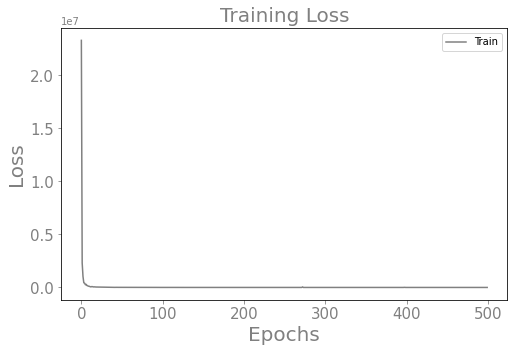

In [211]:
fig, axs = plt.subplots(figsize=(8,5))

axs.plot(history.history['total_loss'], color = 'gray')
axs.set_title('Training Loss', color = 'gray',fontsize =20)
axs.set_xlabel('Epochs', color = "gray", fontsize =20)
axs.set_ylabel('Loss', color = "gray", fontsize =20)
axs.tick_params(axis ='both', colors = 'gray', labelsize = 15)
axs.legend(['Train'])

plt.show()

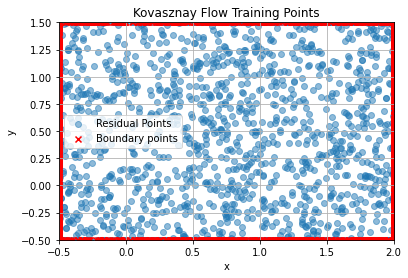

In [213]:
# Plot the random points inside the boundary
plt.scatter(xy[:, 0], xy[:, 1], label='Residual Points', alpha=0.5)

# Plot the boundary points
plt.scatter(x_boundary, y_boundary, label='Boundary points', color='red', marker='x')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Kovasznay Flow Training Points')
plt.legend()
plt.grid(True)

plt.show()

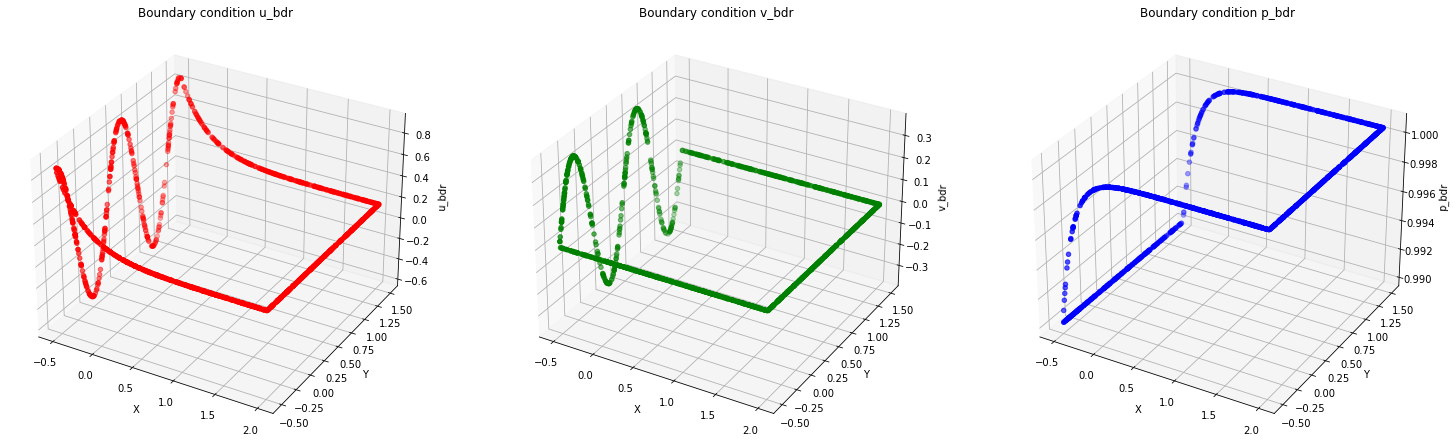

In [215]:
fig = plt.figure(figsize=(20, 10))

# Plot u_bdr
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(x_boundary, y_boundary, u_bdr, c='r', marker='o')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('u_bdr')
ax1.set_title('Boundary condition u_bdr')

# Plot v_bdr
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(x_boundary, y_boundary, v_bdr, c='g', marker='o')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('v_bdr')
ax2.set_title('Boundary condition v_bdr')

# Plot p_bdr
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(x_boundary, y_boundary, d_bdr, c='b', marker='o')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('p_bdr')
ax3.set_title('Boundary condition p_bdr')

plt.tight_layout()
plt.subplots_adjust(wspace = 0.2)
plt.show()

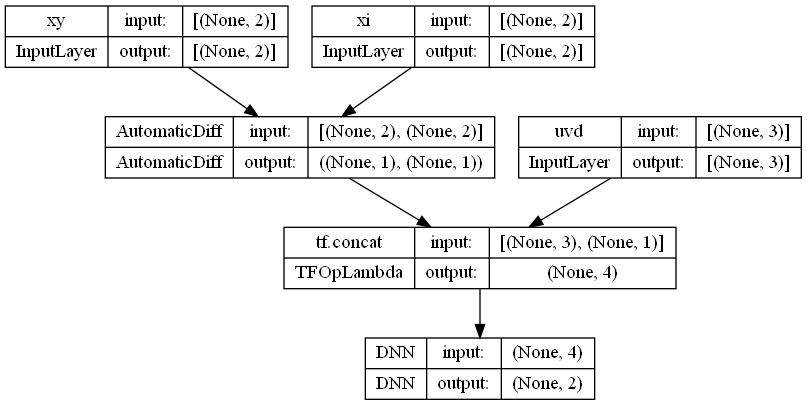

In [219]:
xy = Input(shape = (2,), name = "xy")
xi = Input(shape = (2,), name = "xi")
uvd = Input(shape = (3,), name = "uvd")
x_train = [xy, xi, uvd]

dual_bnn = MaxwellDistribution()  
dnn = DNN()   
bpinn = BPINN(dual_bnn, dnn) 

model = Model(inputs = x_train, outputs = bpinn.call(x_train))
plot_model(model, show_shapes=True, show_layer_names=True)